In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf 


from network import physicsNetwork
from initializer import initData, batchData
from optimizer import pinnOptimizer

# Inspecting Initial Condition

In [2]:
N = 2**15
dt = 1e-13

t = np.linspace(0, N*dt, N)
t = t-t.mean()

In [3]:
L = 1000
nsteps = 2**8 + 1 
zlocs = np.linspace(0, L, nsteps)

In [4]:
alpha = .2e-3 
gamma = 10e-3 
beta2 = 100e3*(1e-30)
regularizer_param = 1

(-64.0, 64.0, 0.0, 0.067138671875)

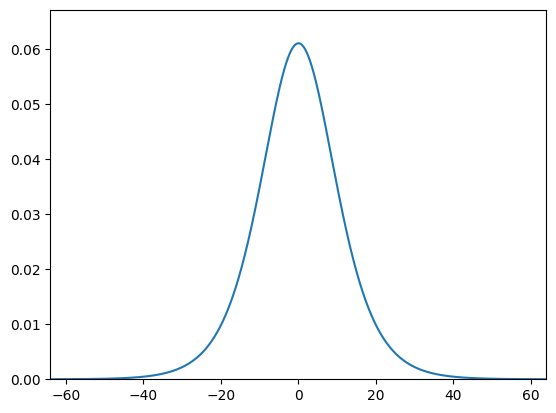

In [5]:
def getPower(u):
    return np.abs(u)**2

def sechPulse(time, amplitude, duration):
    return amplitude/np.cosh(time/duration)

duration = 2**7*dt
amplitude = np.sqrt(np.abs(beta2)/gamma/duration**2)
pulse = sechPulse(t, amplitude, duration)

plt.plot(t*1e12, getPower(pulse))
plt.axis([-duration*5*1e12, duration*5*1e12, 0, 1.1*amplitude**2])

# Initializing Collocation Point

In [6]:
t_new = t[(t>-5*duration) & (t<5*duration)]*1e12

num_train = 1000
num_label = 1000
t_f = t_new[-1]
t_init = t_new[0]

x_f = 1000
x_init = 0 

start_point = np.array([t_init, x_init])
final_point = np.array([t_f, x_f])

def sechPulse(time, amplitude, duration):
    time = time/1e12
    return amplitude/np.cosh(time/duration)

duration = 2**7*dt
amplitude = np.sqrt(np.abs(beta2)/gamma/duration**2)

In [7]:
gen_data = initData()


#collocation point 
col_point = gen_data.init_points(final_point, start_point, num_train)

#initial condition (x = 0)
init_point = np.zeros((num_label, 2))
init_point[..., 0] = gen_data.init_points(t_f, t_init, num_label).reshape(-1)
init_point[..., 1] = x_init*np.ones_like(init_point[..., 1])

u_init = sechPulse(init_point[..., 0], amplitude, duration) #real part
u_init = np.expand_dims(u_init, axis=1)
v_init = np.zeros_like(u_init) #imaginary part

#lower boundary condition (t = t_init)
lower_point = np.zeros((num_label, 2))
lower_point[..., 0] = t_init*np.ones_like(lower_point[..., 0])
lower_point[..., 1] = gen_data.init_points(x_f, x_init, num_label).reshape(-1)

u_lower = np.zeros_like(lower_point[..., 0])
u_lower = np.expand_dims(u_lower, axis=1)
v_lower = np.zeros_like(u_lower)

#upper boundary condition (t = t_f)
upper_point = np.zeros((num_label, 2))
upper_point[..., 0] = t_f*np.ones_like(upper_point[..., 0])
upper_point[..., 1] = gen_data.init_points(x_f, x_init, num_label).reshape(-1)

u_upper = np.zeros_like(upper_point[..., 0])
u_upper = np.expand_dims(u_upper, axis=1)
v_upper = np.zeros_like(u_upper)




## Initialize and Batch Data

In [8]:
preparation = batchData()
preparation.add_collocation_point(col_point)
preparation.add_labelled_data(init_point, u_init, v_init, 'init_point')
preparation.add_labelled_data(lower_point, u_lower, v_lower, 'bound_lower')
preparation.add_labelled_data(upper_point, u_upper, v_upper, 'bound_upper')

batched_data = preparation.batch_data()
keys = preparation.get_keys()

In [9]:
for key in keys:
    print(f'{key}: {len(batched_data[key])}')

col_point: 10
init_point: 10
bound_lower: 10
bound_upper: 10


# Initializing Model

In [10]:
model = physicsNetwork.build()

# Fit Model

In [11]:
alpha = .2e-3 
gamma = 10e-3 
beta2 = 100e3*(1e-30)
regularizer_param = 1
optimizer = pinnOptimizer(model, batched_data, alpha, gamma, beta2)
optimizer.fit(1)

Epoch 1/1


Training Batches:   0%|          | 0/10 [00:00<?, ?batch/s]

tf.Tensor(0.018425556, shape=(), dtype=float32)
tf.Tensor(0.018425556, shape=(), dtype=float32)
tf.Tensor(0.007756015, shape=(), dtype=float32)
tf.Tensor(0.002997867, shape=(), dtype=float32)
tf.Tensor(0.0042330297, shape=(), dtype=float32)
tf.Tensor(0.0054532476, shape=(), dtype=float32)
tf.Tensor(0.030203465, shape=(), dtype=float32)
tf.Tensor(0.04717701, shape=(), dtype=float32)
tf.Tensor(0.030369977, shape=(), dtype=float32)
tf.Tensor(0.0123565085, shape=(), dtype=float32)
tf.Tensor(0.010682022, shape=(), dtype=float32)
tf.Tensor(0.010098362, shape=(), dtype=float32)
tf.Tensor(0.008028814, shape=(), dtype=float32)
tf.Tensor(0.0034182966, shape=(), dtype=float32)
tf.Tensor(0.004998482, shape=(), dtype=float32)
tf.Tensor(0.002529286, shape=(), dtype=float32)
tf.Tensor(0.0015451391, shape=(), dtype=float32)
tf.Tensor(0.0007533269, shape=(), dtype=float32)
tf.Tensor(0.00091421563, shape=(), dtype=float32)
tf.Tensor(0.0017091418, shape=(), dtype=float32)
tf.Tensor(0.0013645124, shape=()

Total Loss: 0.5991:  10%|█         | 1/10 [00:04<00:38,  4.25s/batch]

tf.Tensor(1.7603857e-05, shape=(), dtype=float32)
tf.Tensor(0.0015286038, shape=(), dtype=float32)
tf.Tensor(0.0015286038, shape=(), dtype=float32)
tf.Tensor(0.00014296472, shape=(), dtype=float32)
tf.Tensor(0.0004004806, shape=(), dtype=float32)
tf.Tensor(0.00015659441, shape=(), dtype=float32)
tf.Tensor(2.7481005e-05, shape=(), dtype=float32)
tf.Tensor(0.000121382174, shape=(), dtype=float32)
tf.Tensor(6.636785e-05, shape=(), dtype=float32)
tf.Tensor(7.248197e-05, shape=(), dtype=float32)
tf.Tensor(6.665249e-05, shape=(), dtype=float32)
tf.Tensor(5.657303e-05, shape=(), dtype=float32)
tf.Tensor(2.74593e-05, shape=(), dtype=float32)
tf.Tensor(4.9884846e-05, shape=(), dtype=float32)
tf.Tensor(4.071396e-05, shape=(), dtype=float32)
tf.Tensor(1.7129345e-05, shape=(), dtype=float32)
tf.Tensor(7.8246034e-05, shape=(), dtype=float32)
tf.Tensor(1.3246554e-05, shape=(), dtype=float32)
tf.Tensor(1.407796e-05, shape=(), dtype=float32)
tf.Tensor(1.404131e-05, shape=(), dtype=float32)
tf.Tensor(1

Total Loss: 0.0024:  20%|██        | 2/10 [00:07<00:29,  3.66s/batch]

tf.Tensor(4.40288e-06, shape=(), dtype=float32)
tf.Tensor(3.4067168e-06, shape=(), dtype=float32)
tf.Tensor(3.5799426e-06, shape=(), dtype=float32)
tf.Tensor(3.4931518e-06, shape=(), dtype=float32)
tf.Tensor(3.4375055e-06, shape=(), dtype=float32)
tf.Tensor(0.00018283245, shape=(), dtype=float32)
tf.Tensor(0.00018283245, shape=(), dtype=float32)
tf.Tensor(2.8432907e-05, shape=(), dtype=float32)
tf.Tensor(5.3761716e-05, shape=(), dtype=float32)
tf.Tensor(3.621586e-05, shape=(), dtype=float32)
tf.Tensor(4.3752007e-05, shape=(), dtype=float32)
tf.Tensor(4.130131e-05, shape=(), dtype=float32)
tf.Tensor(3.258827e-05, shape=(), dtype=float32)
tf.Tensor(3.907996e-05, shape=(), dtype=float32)
tf.Tensor(3.623152e-05, shape=(), dtype=float32)
tf.Tensor(2.8319075e-05, shape=(), dtype=float32)
tf.Tensor(3.4739507e-05, shape=(), dtype=float32)
tf.Tensor(3.3290817e-05, shape=(), dtype=float32)
tf.Tensor(2.8943334e-05, shape=(), dtype=float32)
tf.Tensor(2.9279287e-05, shape=(), dtype=float32)
tf.Tens

Total Loss: 0.0024:  20%|██        | 2/10 [00:08<00:35,  4.38s/batch]

tf.Tensor(8.164714e-06, shape=(), dtype=float32)
tf.Tensor(8.099005e-06, shape=(), dtype=float32)
tf.Tensor(7.950401e-06, shape=(), dtype=float32)
tf.Tensor(8.029744e-06, shape=(), dtype=float32)
tf.Tensor(7.93035e-06, shape=(), dtype=float32)


KeyboardInterrupt: 

In [37]:
T, Z = np.meshgrid(t_new, zlocs)
tZ = np.stack((T.flatten(), Z.flatten()), axis = -1)
result = optimizer.model(tZ).numpy() 

result_u = result[:, 0].reshape(T.shape)
result_v = result[:, 1].reshape(T.shape)

In [39]:
result_P = (result_u**2 + result_v**2)

In [38]:
result_P

array([[3.78618024e-05, 3.80334059e-05, 3.82105245e-05, ...,
        1.44386195e-05, 1.47508899e-05, 1.50666292e-05],
       [3.55440920e-06, 3.58097395e-06, 3.60896502e-06, ...,
        5.64085785e-05, 5.67192692e-05, 5.70255543e-05],
       [2.52546088e-05, 2.46245436e-05, 2.39934452e-05, ...,
        5.86887218e-05, 5.89084848e-05, 5.91316348e-05],
       ...,
       [2.87929147e-08, 2.87929147e-08, 2.87929147e-08, ...,
        2.87929147e-08, 2.87929147e-08, 2.87929147e-08],
       [2.87929147e-08, 2.87929147e-08, 2.87929147e-08, ...,
        2.87929147e-08, 2.87929147e-08, 2.87929147e-08],
       [2.87929147e-08, 2.87929147e-08, 2.87929147e-08, ...,
        2.87929147e-08, 2.87929147e-08, 2.87929147e-08]], dtype=float32)

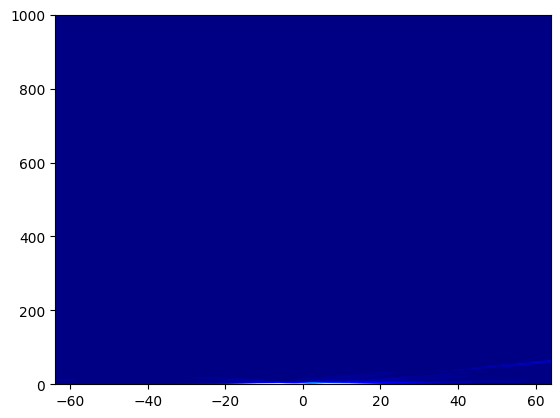

In [42]:
plt.contourf(T, Z, result_P, 100, cmap = 'jet')

In [41]:
nrange = 200
cutoff = -30

def plotPulse2D(matrix, t, zlocs, nrange, cutoff):
    fig,ax = plt.subplots()
    ax.set_title('Pulse Evolution (dB scale)')
    thisT = t[int(len(t)/2-nrange):int(len(t)/2+nrange)]*1e12 
    thisZ = zlocs 
    T, Z = np.meshgrid(thisT, thisZ)

    matrix = matrix[:, int(len(t)/2-nrange):int(len(t)/2+nrange)]
    P = matrix/np.max(matrix)

    P[P<1e-100] = 1e-100
    P_dB = 10*np.log10(P)
    P_dB[P_dB<cutoff] = cutoff

    surf = ax.contourf(T,Z,P_dB, levels = 40)
    ax.set_xlabel('Time (ps)')
    ax.set_ylabel('Distance (m)')
    cbar = fig.colorbar(surf, ax = ax)
    plt.show()